In [ ]:
%pip install catboost

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.3 MB/s eta 0:00:00


# Cleaning the Data

In [ ]:
data = '/content/dielectron.csv'
df = pd.read_csv(data)
df.head(5)

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


In [ ]:
df.columns

Index(['Run', 'Event', 'E1', 'px1 ', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1',
       'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'M'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64  
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64  
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB


In [ ]:
# There's an extra space in front of 'px1' lol
df.rename(columns={"px1 ": "px1"}, inplace=True)

In [ ]:
df.isnull().sum()

Run       0
Event     0
E1        0
px1       0
py1       0
pz1       0
pt1       0
eta1      0
phi1      0
Q1        0
E2        0
px2       0
py2       0
pz2       0
pt2       0
eta2      0
phi2      0
Q2        0
M        85
dtype: int64

In [ ]:
# 85 instances do not have an M value; let's just remove them.
df = df.dropna(subset=['M'])
df.isnull().sum()

Run      0
Event    0
E1       0
px1      0
py1      0
pz1      0
pt1      0
eta1     0
phi1     0
Q1       0
E2       0
px2      0
py2      0
pz2      0
pt2      0
eta2     0
phi2     0
Q2       0
M        0
dtype: int64

In [ ]:
df.duplicated().sum()

23

In [ ]:
# Drop duplicates
df = df.drop_duplicates(subset=['Event'])
df.duplicated().sum()

0

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Run,99891.0,1.479355e+05,9.203464e+02,146511.000000,1.471140e+05,1.479290e+05,1.490110e+05,1.491820e+05
Event,99891.0,4.957540e+08,4.038201e+08,6414.000000,2.023201e+08,3.902504e+08,6.340924e+08,1.791247e+09
E1,99891.0,3.645984e+01,4.122352e+01,0.377928,8.471405e+00,2.174020e+01,5.006405e+01,8.506020e+02
px1,99891.0,1.365795e-01,1.340884e+01,-250.587000,-5.236100e+00,1.416610e-01,5.719210e+00,1.345390e+02
py1,99891.0,1.835378e-01,1.347510e+01,-126.079000,-5.281100e+00,1.005440e-01,5.652355e+00,1.474670e+02
pz1,99891.0,-1.512357e+00,5.162361e+01,-840.987000,-1.589975e+01,-3.138250e-01,1.323200e+01,7.600960e+02
pt1,99891.0,1.441781e+01,1.239161e+01,0.219629,3.773215e+00,1.297230e+01,2.002605e+01,2.655780e+02
eta1,99891.0,-6.421872e-02,1.462651e+00,-4.165380,-1.284755e+00,-6.156030e-02,1.145405e+00,2.622970e+00
phi1,99891.0,2.198577e-02,1.799497e+00,-3.141580,-1.526610e+00,3.513310e-02,1.562645e+00,3.141420e+00
Q1,99891.0,-5.455947e-03,9.999901e-01,-1.000000,-1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
df.to_csv("/content/clean.csv", index=False)

# Data Visualisation

This section will be largely inspired by Danny Bozbay (@danielbozbay), an MSci Theoretical Physics graduate student at Royal Holloway, University of London. His work provided me with the physical insight necessary to make sense of the data. You can find his notebook at https://www.kaggle.com/code/danielbozbay/cern-data-end-to-end-gradient-boosting-0-9-rmse

### Scatter Plots: Numerical Features vs Target

In [ ]:
features = list(df.columns)
features.remove('Run')
features.remove('Event')
features.remove('M')

target = 'M'

def scatter_plot(df:pd.DataFrame=df, feature:list[str]=features, target:str=target):
    '''Creates a multiplot of each feature vs. the target'''
    fix, ax = plt.subplots(4, 4, figsize=(22, 16))

    counter = 0
    for i in (range(4)):
        for j in (range(4)):
            sns.scatterplot(df, x=feature[counter], y=target, ax=ax[i, j], s=3, alpha=0.1)
            counter += 1


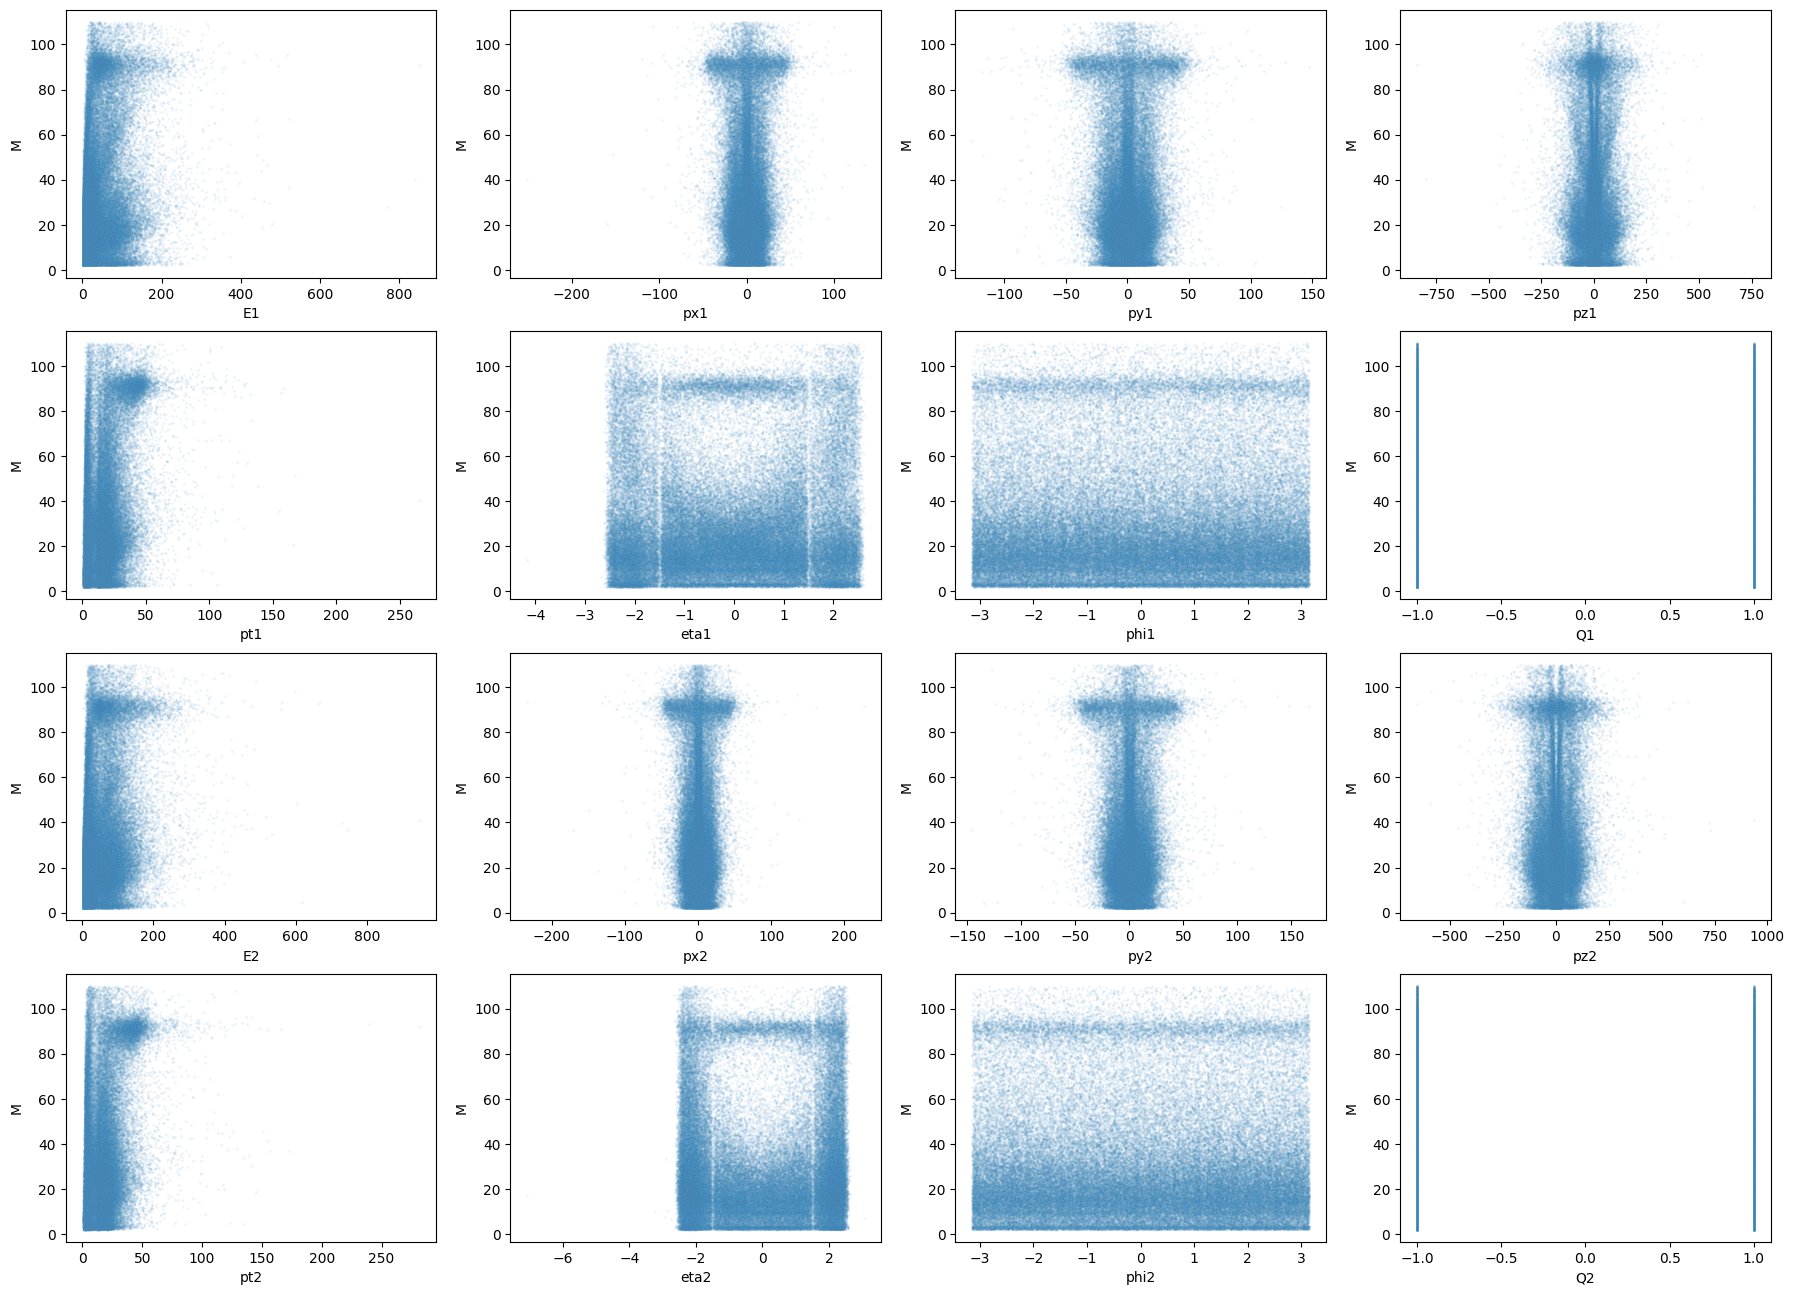

In [ ]:
scatter_plot()

### Invariant Mass Distribution

In [ ]:
def kde_hist_M(df:pd.DataFrame=df, target:str=target):
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    sns.histplot(df[target],bins=50, kde=True, ax=ax)



    plt.title('Distribution of Invariant Mass')
    plt.xlabel('Invariant Mass (GeV)')

    plt.annotate("Z", xy=(91, 1720))  # Z boson
    plt.annotate("$J/\\psi$", xy=(2, 6700))  # J/psi meson
    plt.annotate("$Y(1,2,3S)$", xy=(19, 6200))  # Upsilon meson

    plt.grid(alpha=0.75)

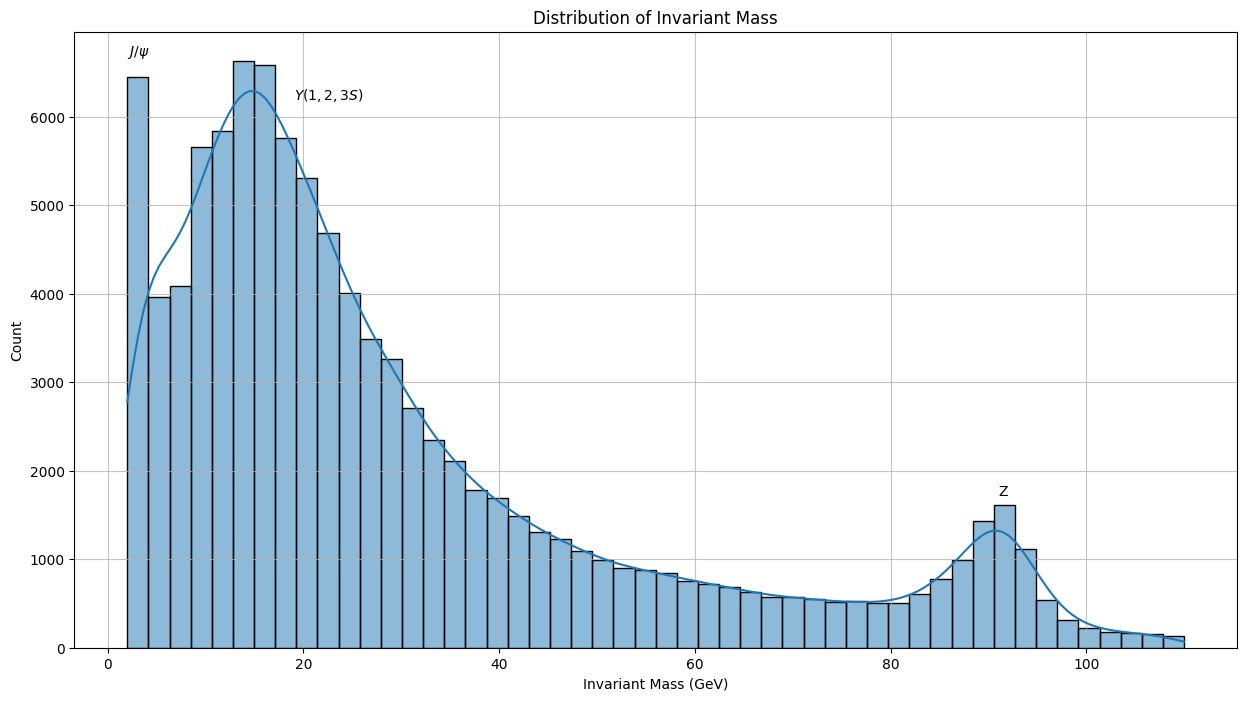

In [ ]:
kde_hist_M()

"We see three invarient mass peaks at approximately 3 GeV, 10 GeV and 90 GeV. These peaks represent the J/psi meson, the Y mesons and the Z boson respectively. [...] Invariant mass peaks in a distribution of decay products (e+ and e- in our case) typically represent the mass of a parent particle that decayed to produce those products. When a particle decays, the invariant mass of the resulting decay products will be clustered around the mass of the parent particle. This is because, according to conservation laws, the total energy and momentum before and after the decay must be the same, and the invariant mass is a way to calculate this." - @danielbozbay, on Kaggle

### Pearson Correlation

In [ ]:
def correlation_matrix(df:pd.DataFrame=df, target:str=target,features:list[str]=features, theme:str='white', figsize:tuple=(12, 8)):
    sns.set_theme(style=theme)

    df_numerical = df.select_dtypes(include=np.number)
    df_numerical = df_numerical.drop(['Run', 'Event'], axis=1) # drop identifiers; irrelevant to correlation
    corr = df_numerical.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))

    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

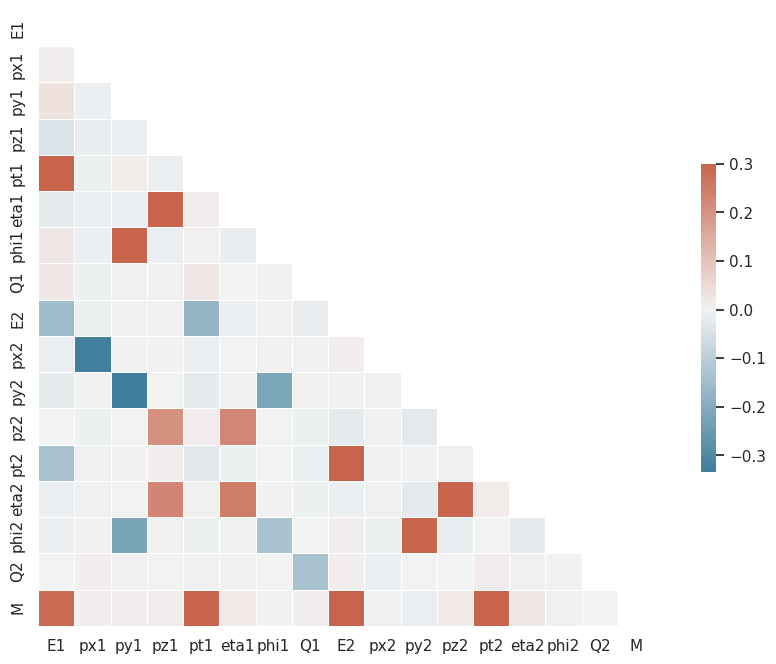

In [ ]:
correlation_matrix()

From the correlation matrix, we can quickly see that the features with highest correlation to the invariant mass are E1 (energy of electron 1), pt1 (transverse momentum of electron 1), E2 and pt2 (same features, for the second electron). The transverse momenta and the energies are themeselves highly correlated to one another, which makes sense.

Another thing worth noting is the inverse correlation between some of the equivalent features of each electron. For example, the second electron momentum along the y-axis is inversely correlated to the first electron's momentum along the same axis. Intuitively, this could be a sign of the particles moving in opposite directions (to be confirmed, I am just hypothesising). In any case, we should be able to exploit these correlations too.

### Outlier Analysis

In [ ]:
def box_kde_jointplot(feature:str, df:pd.DataFrame=df):
    '''Plots a box plot over a KDE plot for a specified feature in the dataset.
    credit to @danielbozbay for the code; this is now one of my favourite plots!
    '''
    fig, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
    )

    # Gridlines
    ax_box.grid(alpha=0.75)
    ax_hist.grid(alpha=0.75)

    # Customizing the flier properties
    flierprops = dict(
        markerfacecolor="r", markersize=2, linestyle="none", markeredgecolor="r"
    )

    # Adding a graph in each part
    sns.boxplot(df[feature], orient="h", ax=ax_box, flierprops=flierprops)
    sns.histplot(df[feature], ax=ax_hist, bins=50, kde=True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel="")

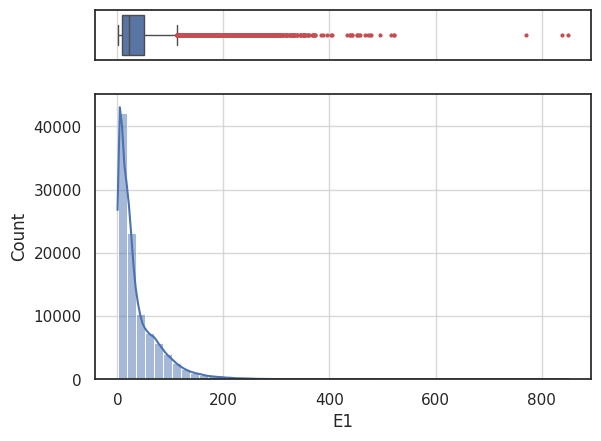

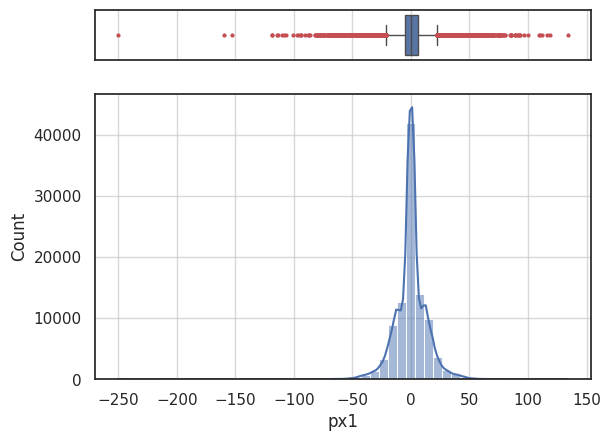

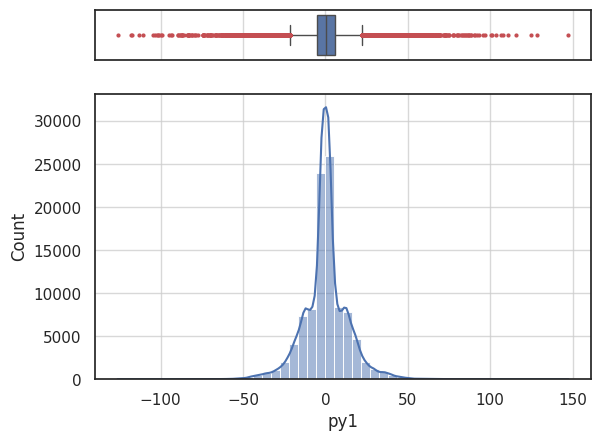

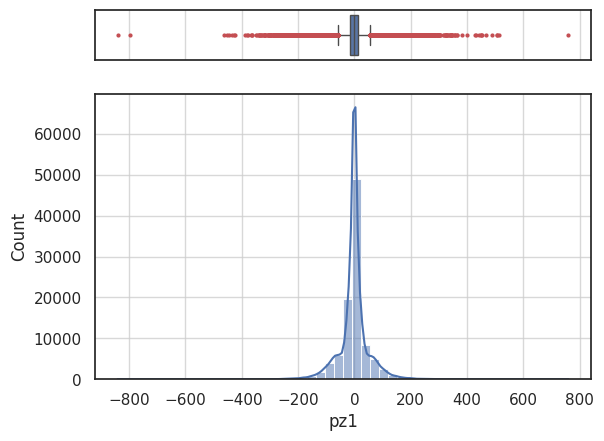

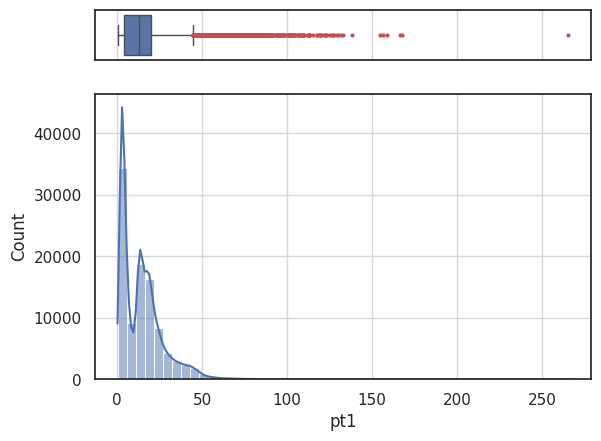

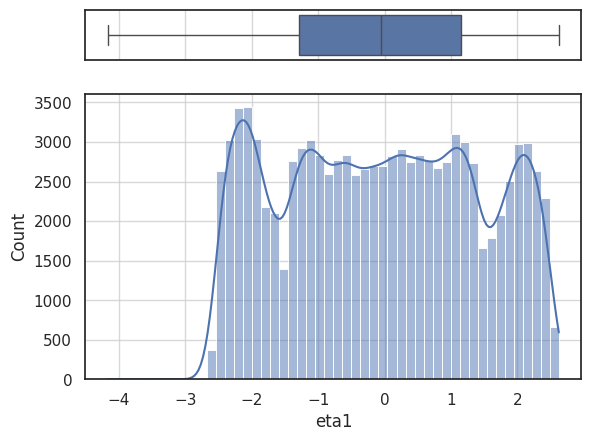

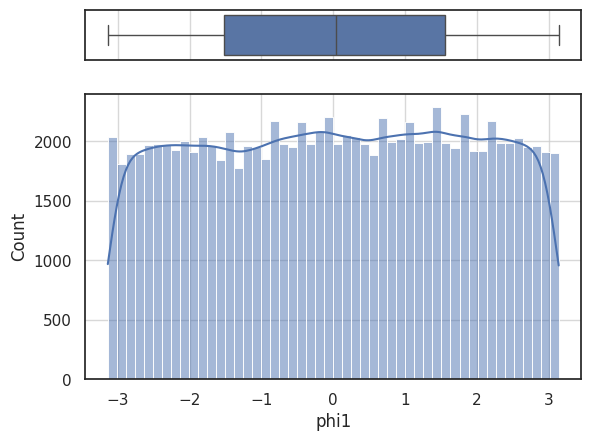

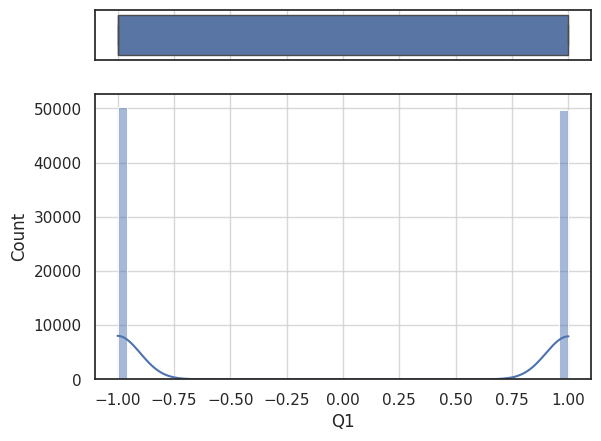

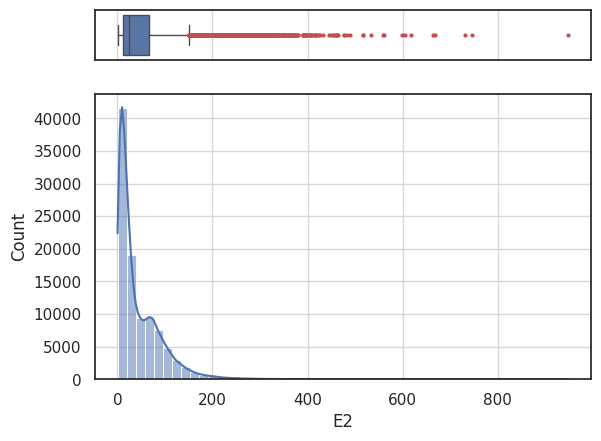

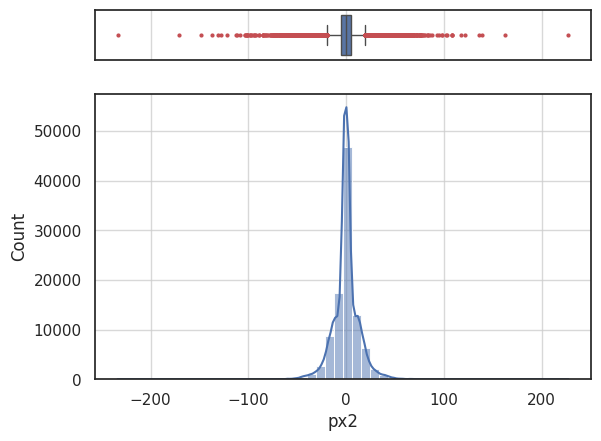

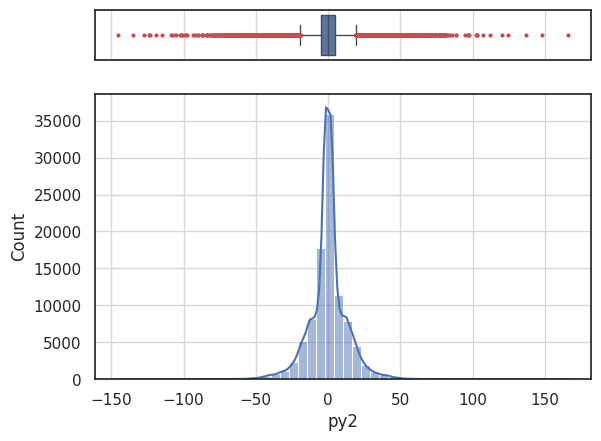

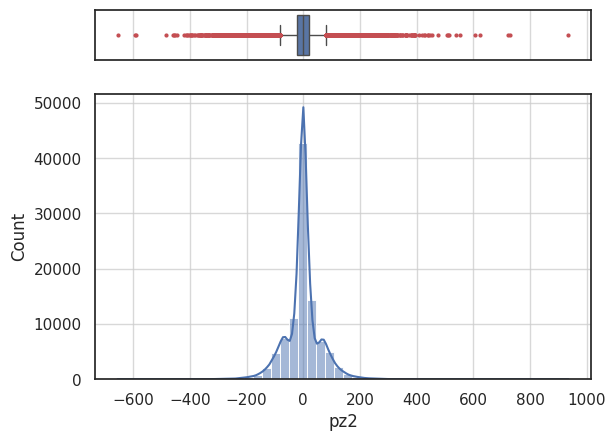

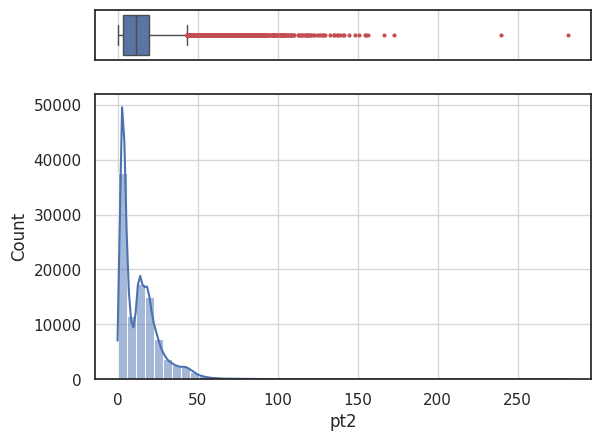

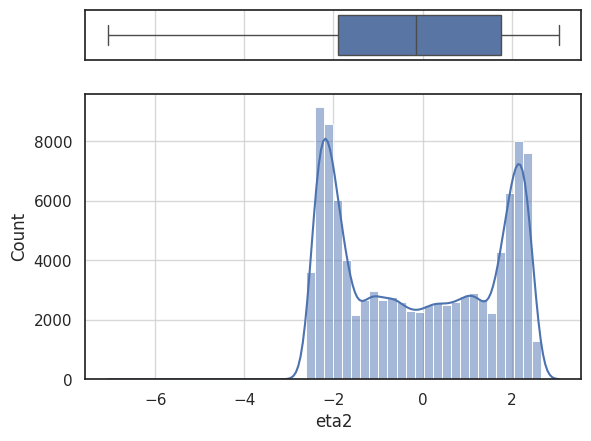

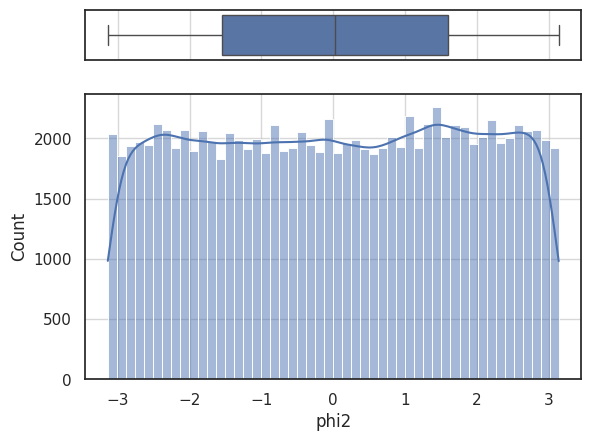

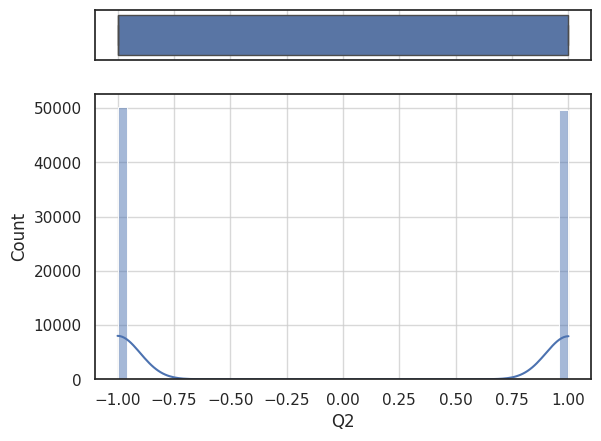

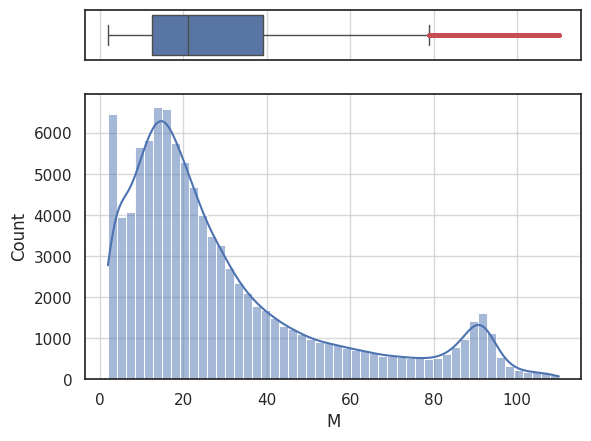

In [ ]:
for feature in df.drop(['Run', 'Event'], axis=1).select_dtypes(include=[np.number]).columns:
    box_kde_jointplot(feature)

A number of the features present a substantial percentage of outlier data points; some of the KDE plots are right tail heavy, and others are heavy on both sides even. We will deal with the outlier points in our preprocessing pipeline.

# A Machine Learning Approach

### Data Preparation

In [ ]:
cols = df.select_dtypes(include=[np.number]).drop(['Q1', 'Q2'], axis=1).columns
new_attributes = [
        'Total Energy',
        'px1px2',
        'py1py2',
        'pz1pz2',
        'pt1pt2',
        'Q1Q2',
        'phi1phi2',
        'eta1eta2'
    ]

cols = cols.tolist() + new_attributes
cols

['Run',
 'Event',
 'E1',
 'px1',
 'py1',
 'pz1',
 'pt1',
 'eta1',
 'phi1',
 'E2',
 'px2',
 'py2',
 'pz2',
 'pt2',
 'eta2',
 'phi2',
 'M',
 'Total Energy',
 'px1px2',
 'py1py2',
 'pz1pz2',
 'pt1pt2',
 'Q1Q2',
 'phi1phi2',
 'eta1eta2']

In [ ]:
def feature_engineer(X:pd.DataFrame) -> pd.DataFrame:

    X = X.copy()

    X['Total Energy'] = X['E1'] + X['E2']

    X['px1px2'] = X['px1'] * X['px2']
    X['py1py2'] = X['py1'] * X['py2']
    X['pz1pz2'] = X['pz1'] * X['pz2']

    X['pt1pt2'] = X['pt1'] * X['pt2']

    X['Q1Q2'] = X['Q1'] * X['Q2']

    X['phi1phi2'] = X['phi2'] * X['phi2']
    X['eta1eta2'] = X['eta2'] * X['eta2']

    return X

In [ ]:
def train_split(path_to_data:str, target:str, add_features=True):
    '''Function to split our data into train and test sets.'''

    df = pd.read_csv(path_to_data)

    y = df[target]
    X = df.drop(target, axis=1)

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = RobustScaler()
    x_train = prep_data(x_train, scaler, add_features, fit=True)
    x_val = prep_data(x_val, scaler, add_features, fit=False)

    return x_train, x_val, y_train, y_val

def prep_data(df: pd.DataFrame, scaler, add_features=True, fit=True) -> pd.DataFrame:
    '''Function to prepare our data for the model.'''

    df_copy = df.copy()

    if add_features:
      df_copy = feature_engineer(df_copy)

    if fit:
        df_ready = scaler.fit_transform(df_copy)
    else:
        df_ready = scaler.transform(df_copy)

    return pd.DataFrame(df_ready, columns=df_copy.columns)

In [ ]:
clean_data = '/content/clean.csv'
df_fresh_extra = pd.read_csv(clean_data)

# 'extra' refers to the addition of engineered features.
X_train_extra, X_val_extra, y_train_extra, y_val_extra = train_split(clean_data, 'M', add_features=True)

print(f"{X_train_extra.shape}\n{X_val_extra.shape}\n{y_train_extra.shape}\n{y_val_extra.shape}\n")
X_val_extra.columns

(79912, 26)
(19979, 26)
(79912,)
(19979,)



Index(['Run', 'Event', 'E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1',
       'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'Total Energy',
       'px1px2', 'py1py2', 'pz1pz2', 'pt1pt2', 'Q1Q2', 'phi1phi2', 'eta1eta2'],
      dtype='object')

In [ ]:
df_fresh = pd.read_csv(clean_data)

X_train, X_val, y_train, y_val = train_split(clean_data, 'M', add_features=False)

print(f"{X_train.shape}\n{X_val.shape}\n{y_train.shape}\n{y_val.shape}\n")

(79912, 18)
(19979, 18)
(79912,)
(19979,)



### Model Building Pipelines

In [ ]:
def build_rfc(add_features:bool, path_to_data:str, target:str='M'):
    '''Build a RandomForestRegressor and evaluates it using Cross-Validation with 5 folds.'''

    X_train, X_val, y_train, y_val = train_split(path_to_data, target, add_features)

    rfc_reg = RandomForestRegressor()
    scores = cross_val_score(rfc_reg, X_train, y_train, cv=5)

    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    rfc_reg.fit(X_train, y_train)

    return rfc_reg, X_val, y_val # X_val and y_val will be used for hyperparameter tuning.


In [ ]:
rfc_regressor, X_val, y_val = build_rfc(True, clean_data, "M")

Accuracy: 0.99 (+/- 0.00)


### Dimensionality Reduction

Training a RandomForestRegressor with all 24 features is costly in terms of time and computational resoources. Let's use PCA to try and reduce the input vectors to a minimum number of dimensions; without losing too much accuracy.

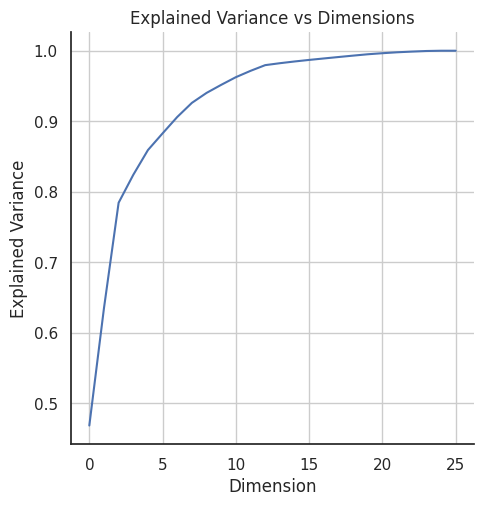

In [ ]:
df_fresh = pd.read_csv(clean_data)

X_train, X_val, y_train, y_val = train_split(clean_data, 'M', True)

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

sns.relplot(cumsum, kind="line")
plt.xlabel('Dimension')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs Dimensions')

plt.grid()

From the Explained Variance vs Dimension plot above, we should be able to reduce the dimension of our inputs to d = 11 and not lose too much info, as the curve grows very slowly after that point.

In [ ]:
def build_rfc_reduced_dim(add_features:bool, path_to_data:str, target:str='M'):
    '''
      Build a RandomForestRegressor and evaluates it using Cross-Validation with 5 folds.
      This time, the input is of dimension 11, down from 24.
    '''
    X_train, X_val, y_train, y_val = train_split(path_to_data, target, add_features)

    pca = PCA(n_components=11)

    X11D_train = pca.fit_transform(X_train)
    X11D_val = pca.fit_transform(X_val)

    rfc_reg = RandomForestRegressor()
    scores = cross_val_score(rfc_reg, X11D_train, y_train, cv=2)

    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    rfc_reg.fit(X_train, y_train)

    return rfc_reg, X11D_val, y_val # X_val and y_val will be used for hyperparameter tuning.

In [ ]:
rfc_reg_pca = build_rfc_reduced_dim(True, clean_data)

Accuracy: 0.98 (+/- 0.00)


In [ ]:
def build_gradient_boosted_ensemble(add_features:bool, path_to_data:str, target:str='M'):
    '''Build a boosted ensemble model using 3 regressors. '''
    x_train, x_val, y_train, y_val = train_split(path_to_data, target, bin)

    lgbm = lgb.LGBMRegressor()
    catboost = CatBoostRegressor()
    xgb = XGBRegressor()

    voting_reg = VotingRegressor(
    estimators=[('lrc_est', xgb), ('lgbm_est', lgbm), ('kitty', catboost)],
    verbose=0)

    # test
    scores_lgbm = cross_val_score(lgbm, x_train, y_train, cv=2)
    scores_catboost = cross_val_score(catboost, x_train, y_train, cv=2)
    scores_xgb = cross_val_score(xgb, x_train, y_train, cv=2)
    scores_voting_reg = cross_val_score(voting_reg, x_train, y_train, cv=2)

    print("LGBM Accuracy: %0.2f (+/- %0.2f)" % (scores_lgbm.mean(), scores_lgbm.std() * 2))
    print("Catboost Accuracy: %0.2f (+/- %0.2f)" % (scores_catboost.mean(), scores_catboost.std() * 2))
    print("XGBoost Accuracy: %0.2f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std() * 2))
    print("Ensemble Accuracy: %0.2f (+/- %0.2f)" % (scores_voting_reg.mean(), scores_voting_reg.std() * 2))

    voting_reg.fit(x_train, y_train)

    return voting_reg, x_val, y_val

In [ ]:
voting_regressor, X_val, y_val = build_gradient_boosted_ensemble(True, clean_data)

Oh boy, big data leakage. Cross val scores of 1.00 are simply not plausible. After a bit of looking around, I belive I've found the culprit; RobustScaler should be fitted on the training data only, *then* used to transform everything.

In [ ]:
y_pred = voting_regressor.predict(X_val)
RMSE = mean_squared_error(y_val, y_pred, squared=False)

In [ ]:
std_dev = y_val.std()

print(f'RMSE: {round(RMSE, 3)}')
print(f'Standard Deviation of Validation Targets: {round(std_dev, 3)}')

RMSE: 1.32
Standard Deviation of Validation Targets: 25.442


We achieved a RMSE of 1.32 with no tuning. Considering the 25.442 standard deviation presented by the targets, that is not bad at all! Note however that the k-fold cross validation score are still super super suspicious to me. I changed the way I was prepping the data and all, but I am still suspecting a data leakage somewhere. In the next section, I will build the model from scratch to avoid any weird stuff.

### Model Selection and Hyperparameter Tuning

Tuning the hyperparameters of an ensemble model such as ours involves tuning the hyperparameters of all its base estimators. In our case, our voting ensemble is composed of three standalone models: LGBMRegressor, CatBoostRegressor and XGBRegressor.

To make the task a bit simpler (and to save my computer from melting), we will disassemble the ensemble and use a single estimator as our final model, and that will be the one we will tune. All the estimators showed sensibly the same accuracy during cross validation, so I will just pick CatBoost, because I like cats.

In [ ]:
# get fresh data set
df_model = pd.read_csv('/content/clean.csv')

# train/test split
train_set, test_set = train_test_split(df, test_size=0.1, random_state=42) # put test_set away until end

print(train_set.shape)
print(test_set.shape)

(89901, 19)
(9990, 19)


In [ ]:
train_set_engineered = feature_engineer(train_set) # add custom features

y = train_set_engineered['M'] # target
X = train_set_engineered.drop('M', axis=1) # features

print(y.shape)
print(X.shape)

(89901,)
(89901, 26)


In [ ]:
# scale features
X = RobustScaler().fit_transform(X)

# project down to 11-dimensional space

pca = PCA(n_components=11)

X11D = pca.fit_transform(X)

print(X11D.shape)
X11D

(89901, 11)


array([[-2.5551574 , -0.02584966,  0.04191922, ...,  0.54747433,
         0.85511502,  0.12044134],
       [-3.4296662 ,  1.06016896, -1.10357308, ...,  2.06937826,
         1.72521864,  1.32865541],
       [ 4.10229933,  3.80808016,  1.24043063, ...,  0.51744105,
        -0.33979287, -0.9886266 ],
       ...,
       [-2.39947035, -0.23018595,  0.02745295, ..., -0.42124985,
        -0.46784866, -0.06263527],
       [-2.56560072, -0.15380311,  0.27414381, ..., -0.11028332,
         0.04902709,  0.04230536],
       [-1.86004814,  1.26198254,  2.68564687, ..., -1.20741659,
        -2.171031  ,  0.64675706]])

In [ ]:
# split for model training and validation
X_train_11D, X_val_11D, y_train, y_val = train_test_split(X11D, y, test_size=0.2, random_state=42)

print(X_train_11D.shape)
print(X_val_11D.shape)
print(y_train.shape)
print(y_val.shape)

(71920, 11)
(17981, 11)
(71920,)
(17981,)


In [ ]:
# build model and evaluate
a_cat_that_knows_a_lot_about_electrons = CatBoostRegressor()
a_cat_that_knows_a_lot_about_electrons.fit(X_train_11D, y_train)

Learning rate set to 0.080457
0:	learn: 23.6169053	total: 14.9ms	remaining: 14.9s
1:	learn: 22.0580877	total: 27.9ms	remaining: 13.9s
2:	learn: 20.6484655	total: 41ms	remaining: 13.6s
3:	learn: 19.3635678	total: 53.9ms	remaining: 13.4s
4:	learn: 18.1609972	total: 67ms	remaining: 13.3s
5:	learn: 17.0792666	total: 80ms	remaining: 13.2s
6:	learn: 16.0906725	total: 93.1ms	remaining: 13.2s
7:	learn: 15.1798355	total: 106ms	remaining: 13.1s
8:	learn: 14.3516067	total: 118ms	remaining: 13s
9:	learn: 13.6078568	total: 136ms	remaining: 13.4s
10:	learn: 12.9126272	total: 149ms	remaining: 13.4s
11:	learn: 12.2861249	total: 161ms	remaining: 13.3s
12:	learn: 11.7352165	total: 178ms	remaining: 13.5s
13:	learn: 11.2256904	total: 191ms	remaining: 13.5s
14:	learn: 10.7609010	total: 205ms	remaining: 13.4s
15:	learn: 10.2973984	total: 218ms	remaining: 13.4s
16:	learn: 9.8807284	total: 235ms	remaining: 13.6s
17:	learn: 9.5025318	total: 249ms	remaining: 13.6s
18:	learn: 9.1751129	total: 265ms	remaining: 13

In [ ]:
y_pred_cat = a_cat_that_knows_a_lot_about_electrons.predict(X_val_11D)

In [ ]:
std_dev = y_val.std()
print('R-squared: ', round(r2_score(y_val, y_pred_cat), 3))
print('RMSE: ', round(mean_squared_error(y_val, y_pred_cat, squared=False), 3))
print('Standard Deviation of Validation Set ', round(std_dev, 3))

R-squared:  0.989
RMSE:  2.613
Standard Deviation of Validation Set  25.073


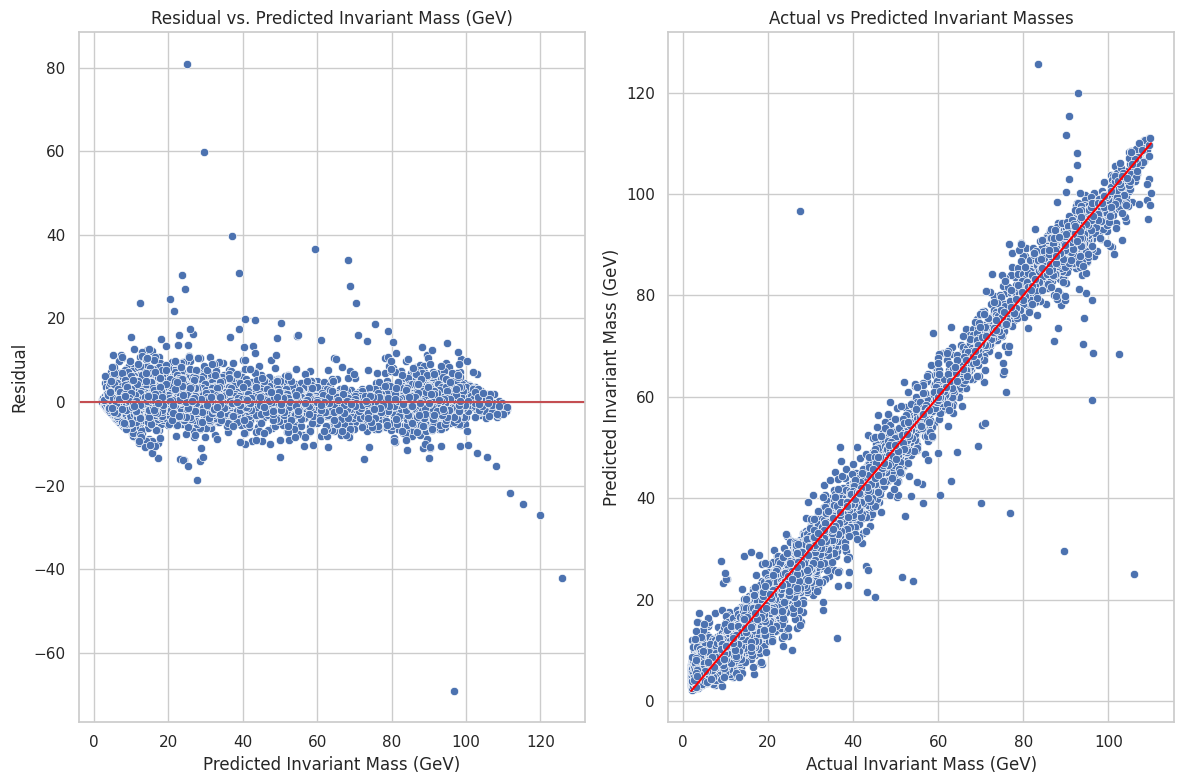

In [ ]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

residuals = y_val - y_pred_cat

sns.scatterplot(x=y_pred_cat, y=residuals, ax=ax[0])
ax[0].set_xlabel('Predicted Invariant Mass (GeV)')
ax[0].set_ylabel('Residual')
ax[0].axhline(y=0, color='r', linestyle='-')
ax[0].set_title('Residual vs. Predicted Invariant Mass (GeV)')

sns.scatterplot(x=y_val, y=y_pred_cat, ax=ax[1])
ax[1].set_xlabel('Actual Invariant Mass (GeV)')
ax[1].set_ylabel('Predicted Invariant Mass (GeV)')
ax[1].set_title('Actual vs Predicted Invariant Masses')
ax[1].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')

plt.tight_layout()

Some very encouraging results. The RMSE of 2.576 is substantially below the validation set's std (25.073), pointing at a good fit. I am also happy that this RMSE is currently higher than the one obtained from the voting regressor; it renders me more confident in saying that any data leakage was avoided.

Looking at the plots, the residuals are centered around 0 and lack any structure, which is a good sign. The Predicted vs Actual Invariant Mass plot is also encouraging, showing a linear trend between the two quantities.

Let's now tune the model, and try to get even better results.

In [ ]:
# %pip install optuna

In [ ]:
# import optuna
# from optuna.samplers import TPESampler
# # This is my first time using Optuna to tune hyperparameters (I usually use Grid or RandomizedSearchCV).

# # we first define an objective fucntion
# def objective(trial):
#     # hyperparameter space
#     catboost_params = {
#         'iterations': trial.suggest_int('iterations', 50, 300),
#         'depth': trial.suggest_int('depth', 1, 7),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'verbose': False
#     }

#     model = CatBoostRegressor(**catboost_params)

#     scores = cross_val_score(model, X_train_11D, y_train, cv=5)

#     # Optuna will attempt to minimize this score
#     return -scores.mean()

# # Optuna study that will optimize objective function
# study = optuna.create_study(sampler=TPESampler(seed=42), direction='minimize')
# study.optimize(objective, n_trials=100)

# print(study.best_params)

After 100 trials, the Optuna minimizes the function at ~ -0.985. The best combination of CatBoost hyperparameters it found, given the space of possibilities I let it have, are:

```{'iterations': 293, 'depth': 7, 'learning_rate': 0.09982992055487182, 'l2_leaf_reg': 0.006766433978949287, 'border_count': 197}```



In [ ]:
# optimized model
cat_who_is_also_a_particle_physicist = CatBoostRegressor(iterations=293, depth=7, learning_rate=0.09982992055487182, l2_leaf_reg=0.006766433978949287, border_count=197)
cat_who_is_also_a_particle_physicist.fit(X_train_11D, y_train)

0:	learn: 23.1559410	total: 18.8ms	remaining: 5.48s
1:	learn: 21.2823081	total: 34.1ms	remaining: 4.96s
2:	learn: 19.5771156	total: 49.3ms	remaining: 4.77s
3:	learn: 18.0133613	total: 64.1ms	remaining: 4.63s
4:	learn: 16.6532737	total: 78.7ms	remaining: 4.53s
5:	learn: 15.4257785	total: 93.6ms	remaining: 4.48s
6:	learn: 14.3134779	total: 108ms	remaining: 4.42s
7:	learn: 13.3428843	total: 123ms	remaining: 4.36s
8:	learn: 12.4723653	total: 138ms	remaining: 4.34s
9:	learn: 11.6853169	total: 154ms	remaining: 4.34s
10:	learn: 11.0125142	total: 168ms	remaining: 4.31s
11:	learn: 10.3889005	total: 189ms	remaining: 4.42s
12:	learn: 9.8173558	total: 203ms	remaining: 4.37s
13:	learn: 9.3070196	total: 220ms	remaining: 4.38s
14:	learn: 8.8804591	total: 237ms	remaining: 4.39s
15:	learn: 8.4940680	total: 251ms	remaining: 4.35s
16:	learn: 8.1366883	total: 266ms	remaining: 4.32s
17:	learn: 7.8339322	total: 280ms	remaining: 4.28s
18:	learn: 7.5798518	total: 295ms	remaining: 4.25s
19:	learn: 7.3191582	to

In [ ]:
y_pred_cat_better = cat_who_is_also_a_particle_physicist.predict(X_val_11D)

In [ ]:
std_dev_hopefully_better = y_val.std()
print('R-squared: ', round(r2_score(y_val, y_pred_cat_better), 3))
print('RMSE: ', round(mean_squared_error(y_val, y_pred_cat_better, squared=False), 3))
print('Standard Deviation of Validation Set ', round(std_dev_hopefully_better, 3))

R-squared:  0.985
RMSE:  3.065
Standard Deviation of Validation Set  25.073


It performs worse! Ok, let's try something else. Giving up on Optuna for now, and going back to what I know: RandomizedSearchCV.

In [ ]:
# random_search = RandomizedSearchCV(
#     estimator=CatBoostRegressor(),
#     param_distributions={
#         "iterations": np.arange(1000, 3100, 100).tolist(),
#         "depth": np.linspace(4, 10, 7).astype(int).tolist(),
#         "l2_leaf_reg": np.linspace(1, 10, 10).tolist(),
#         "subsample": np.linspace(0.5, 1, 6).tolist(),
#         "colsample_bylevel": np.linspace(0.5, 1, 6).tolist(),
#         # "learning_rate": np.linspace()
#     },
#     n_iter=10,
#     cv=3,
#     scoring="neg_root_mean_squared_error",
#     error_score="raise",
#     verbose=0,
#     random_state=42,
# )

# # Im thinking usin a subset of the training for tuning could prevent overfitting on the training set and loss of
# # generalization; in the sense that it will not consstrain itself to finding the past hyperparameters to
# # the point of overfitting on the training set (just a hypethesis though).
# X_train_subset = X_train.sample(frac=0.2, random_state=42)
# Y_train_subset = y_train.sample(frac=0.2, random_state=42)

# X_train_subset, Y_train_subset = X_train_subset[:len(Y_train_subset)], Y_train_subset

# random_search.fit(X_train_subset, Y_train_subset)

# print(f"Best parameters: {random_search.best_params_}")
# print(f"Best score: {random_search.best_score_}")

{{'subsample': 0.7, 'l2_leaf_reg': 6.0, 'iterations': 2000, 'depth': 4, 'colsample_bylevel': 1.0}
Best score: -25.822228642685275

In [ ]:
cat_but_smarter = CatBoostRegressor(subsample=0.7, l2_leaf_reg=6, iterations=2000, depth=4, colsample_bylevel=1.0)
cat_but_smarter.fit(X_train_11D, y_train)

0:	learn: 24.7043893	total: 13.9ms	remaining: 27.7s
1:	learn: 24.1304131	total: 23.7ms	remaining: 23.7s
2:	learn: 23.5790134	total: 32.7ms	remaining: 21.7s
3:	learn: 23.0384957	total: 41.7ms	remaining: 20.8s
4:	learn: 22.5254285	total: 50.6ms	remaining: 20.2s
5:	learn: 22.0361319	total: 59.5ms	remaining: 19.8s
6:	learn: 21.5490686	total: 68.5ms	remaining: 19.5s
7:	learn: 21.0813397	total: 77.6ms	remaining: 19.3s
8:	learn: 20.6319905	total: 86.5ms	remaining: 19.1s
9:	learn: 20.1851736	total: 95.4ms	remaining: 19s
10:	learn: 19.7635001	total: 104ms	remaining: 18.8s
11:	learn: 19.3585683	total: 115ms	remaining: 19.1s
12:	learn: 18.9645618	total: 124ms	remaining: 19s
13:	learn: 18.5779901	total: 133ms	remaining: 18.9s
14:	learn: 18.2121308	total: 143ms	remaining: 18.9s
15:	learn: 17.8520324	total: 151ms	remaining: 18.8s
16:	learn: 17.4931051	total: 161ms	remaining: 18.8s
17:	learn: 17.1584213	total: 170ms	remaining: 18.7s
18:	learn: 16.8292846	total: 179ms	remaining: 18.7s
19:	learn: 16.51

In [ ]:
y_pred_randomizedCv = cat_but_smarter.predict(X_val_11D)

In [ ]:
std_dev_randomizedCV = y_val.std()
print('R2-squared: ', round(r2_score(y_val, y_pred_randomizedCv), 3))
print('RMSE: ', round(mean_squared_error(y_val, y_pred_randomizedCv, squared=False), 3))
print('Standard Deviation of Validation Set ', round(std_dev_randomizedCV, 3))

R2-squared:  0.982
RMSE:  3.331
Standard Deviation of Validation Set  25.073


Okay, still no good. I blame the reduced dimensionality, so let's go back to fully-informed inputs.

In [ ]:
final_cat = CatBoostRegressor(subsample=0.7, l2_leaf_reg=6, iterations=2000, depth=4, colsample_bylevel=1.0)
X_train, X_val, y_train, y_val = train_split(clean_data, 'M', True)
final_cat.fit(X_train, y_train)

0:	learn: 24.5802586	total: 38.4ms	remaining: 1m 16s
1:	learn: 23.9770845	total: 68.6ms	remaining: 1m 8s
2:	learn: 23.3832258	total: 90.8ms	remaining: 1m
3:	learn: 22.8122440	total: 105ms	remaining: 52.2s
4:	learn: 22.2575586	total: 120ms	remaining: 47.8s
5:	learn: 21.7172274	total: 135ms	remaining: 44.7s
6:	learn: 21.1952319	total: 149ms	remaining: 42.4s
7:	learn: 20.6899567	total: 164ms	remaining: 40.9s
8:	learn: 20.2033507	total: 182ms	remaining: 40.2s
9:	learn: 19.7332901	total: 198ms	remaining: 39.4s
10:	learn: 19.2734105	total: 219ms	remaining: 39.5s
11:	learn: 18.8362602	total: 231ms	remaining: 38.2s
12:	learn: 18.4048500	total: 249ms	remaining: 38s
13:	learn: 17.9812617	total: 260ms	remaining: 36.9s
14:	learn: 17.5713959	total: 272ms	remaining: 36s
15:	learn: 17.1817167	total: 284ms	remaining: 35.2s
16:	learn: 16.8054460	total: 296ms	remaining: 34.6s
17:	learn: 16.4338136	total: 314ms	remaining: 34.6s
18:	learn: 16.0699782	total: 336ms	remaining: 35s
19:	learn: 15.7158218	total

In [ ]:
y_pred_final = final_cat.predict(X_val)

print('R2-squared: ', round(r2_score(y_val, y_pred_final), 3))
print('RMSE: ', round(mean_squared_error(y_val, y_pred_final, squared=False), 3))
print('Standard Deviation of Validation Set ', round(std_dev_randomizedCV, 3))

R2-squared:  0.996
RMSE:  1.615
Standard Deviation of Validation Set  25.073


RMSE 1.615, a new high score. As I thought, going from 26 to 11 dimensions is what limited us in our tuning, not Optuna/RandomizedSearchCV.

### Results and Conclusion

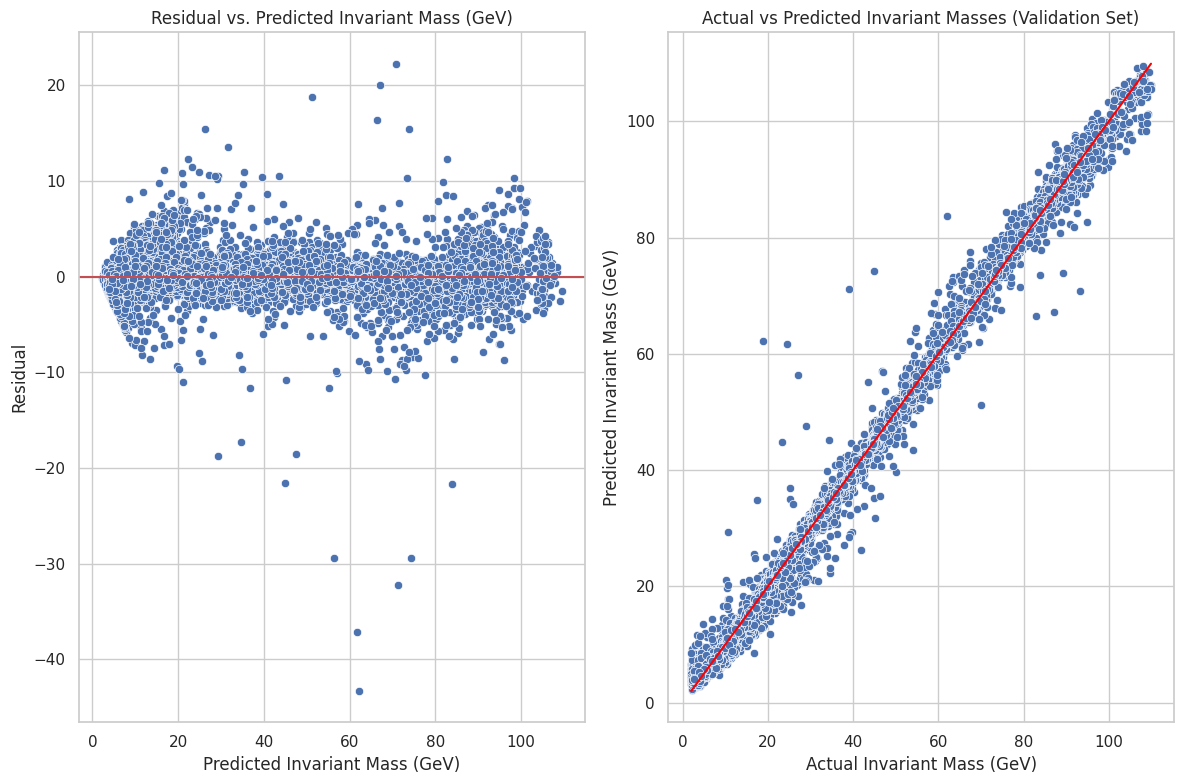

In [ ]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

residuals = y_val - y_pred_final

sns.scatterplot(x=y_pred_final, y=residuals, ax=ax[0])
ax[0].set_xlabel('Predicted Invariant Mass (GeV)')
ax[0].set_ylabel('Residual')
ax[0].axhline(y=0, color='r', linestyle='-')
ax[0].set_title('Residual vs. Predicted Invariant Mass (GeV)')

sns.scatterplot(x=y_val, y=y_pred_final, ax=ax[1])
ax[1].set_xlabel('Actual Invariant Mass (GeV)')
ax[1].set_ylabel('Predicted Invariant Mass (GeV)')
ax[1].set_title('Actual vs Predicted Invariant Masses (Validation Set)')
ax[1].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')

plt.tight_layout()

After some tuning, we were able to go from an RMSE of 2.5 to around 1.6, an improvement of ~ 38%. In more concrete terms, our final model predicts invariant masses within 1.6 GeV of their actual values, on average. Visually, the lower RMSE translates to a tighter distribution around the curve in Actual vs Predicted Invariant Masses plot.

Looking back at the data's explained variance, I believe projecting down to an 11-dimensional space was overdoing it. If I had to do it again, I would go with 20 components instead; a milder reduction of the dimensionality, but one that saves us time and computational woes nonetheless. The decision boils down to if we're ready to accept the resources-for-performance tradeoff PCA incurs.

And that's it! We have a simple regression model capable of predicting invariant masses based on collision events readouts. I am pretty happy with the project, as it gave me a first feel of what's it like to deal with experimental data related to particle physics. I feel like I learned a lot, especially about making data-driven decisions when time comes to build the model and tune it. What I would like to do next is apply a deep learning approach to a similar problem, and see how the workflow differs. Ultimately, I would like to become good enough at analysing data of this type to be able to contribute to real world research as an undergrad student. Let's keep working!